In [0]:
import spacy as spacy
import numpy as np
import wordcloud
from wordcloud import WordCloud
from collections import OrderedDict
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from google.colab import files
from heapq import nlargest

In [53]:
uploaded = files.upload()

Saving conv_ben_sara.txt to conv_ben_sara.txt


In [100]:
document1 = open('conv_ben_sara.txt', 'r').read()


# Build a List of Stopwords
stopwords = list(STOP_WORDS)


nlp = spacy.load('en')
# Build an NLP Object
docx = nlp(document1)

# Tokenization of Text
mytokens = [token.text for token in docx]

# Build Word Frequency
# word.text is tokenization in spacy
word_frequencies = {}
for word in docx:
    if word.text not in stopwords:
            if word.text not in word_frequencies.keys():
                word_frequencies[word.text] = 1
            else:
                word_frequencies[word.text] += 1
                
word_frequencies

# Maximum Word Frequency
maximum_frequency = max(word_frequencies.values())

for word in word_frequencies.keys():  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequency)

#word frequency distribution
# word_frequencies


# Sentence Tokens
sentence_list = [ sentence for sentence in docx.sents ]

# Sentence Score via comparrng each word with sentence
sentence_scores = {}  
for sent in sentence_list:  
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if len(sent.text.split(' ')) < 10:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word.text.lower()]
                    else:
                        sentence_scores[sent] += word_frequencies[word.text.lower()]
                        
# Sentence Score Table
#sentence_scores


# FINDING TOP N SENTENCE WITH LARGEST SCORE
summarized_sentences = nlargest(3, sentence_scores, key=sentence_scores.get)
#summarized_sentences

# # List Comprehension of Sentences Converted From Spacy.span to strings
# final_sentences = [ w.text for w in summarized_sentences ]
# summary = ' '.join(final_sentences)
# summary

# Convert Sentences from Spacy Span to Strings for joining entire sentence
for w in summarized_sentences:
    print(w.text)


I think it's pretty cool.
 
I think it's a bit creepy.
 
and I think you could be very helpful.
 


In [98]:
print("The summary reduced the text from " + str(len(summary)) + " to " + str(len(document1)) + " characters")

The summary reduced the text from 56 to 495 characters


# Keyword Extraction

In [101]:


#DIFFERENT OPTION:
# nlp = spacy.load('en_core_web_sm')
# content = document1

# doc = nlp(content)

# #candidate_pos = ['NOUN', 'PROPN', 'VERB']
# candidate_pos = ['NOUN']
# sentences = []

# for sent in doc.sents:
#     selected_words = []
#     for token in sent:
#         if token.pos_ in candidate_pos and token.is_stop is False:
#             selected_words.append(token)
#     sentences.append(selected_words)
    
# #Each word is a node in PageRank. We set the window size as k.

# print(sentences)



nlp = spacy.load('en_core_web_sm')

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            #print(key + ' - ' + str(value))
            print(key)
            if i > number:
                break
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight
        
        
tr4w = TextRank4Keyword()
tr4w.analyze(document1, candidate_pos = ['NOUN'], window_size=10, lower=True)
print("The most common keywords in the documents are:")
print("------------------------------")
tr4w.get_keywords(5)

The most common keywords in the documents are:
------------------------------
goodnight
trees
accent
website
tool
salary
bit


# Word Cloud

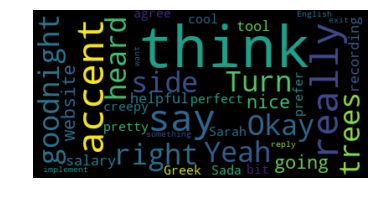

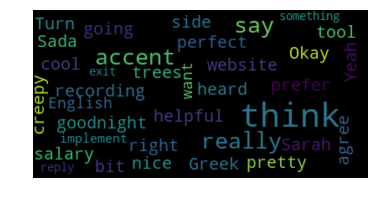

NameError: ignored

In [105]:
# Read the whole text.
text = document1

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#The pil way (if you don't have matplotlib)
image = wordcloud.to_image()
image.show()
 

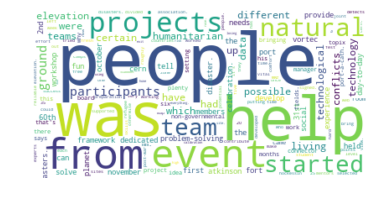

In [50]:
#!pip install multidict
import multidict as multidict

import numpy as np

import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict


def makeImage(text):

    wc = WordCloud(background_color="white", max_words=1000)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
#d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()


text = document1
makeImage(getFrequencyDictForText(text))